# CSAI 301 - Project Phase 2
## Vacuum Cleaner Robot Problem
### Ahmed Wael 202201415
**********************************

# The Code
**************************************

### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import time
from copy import deepcopy
from typing import List, Tuple, Optional, Dict
import seaborn as sns
from collections import defaultdict


### Connect Four Game Environment

In [7]:
class ConnectFour:
    
    def __init__(self, rows=6, cols=7):
        self.ROWS = rows
        self.COLS = cols
        self.board = np.zeros((rows, cols), dtype=int)
        self.current_player = 1  # Player 1 starts
        self.last_move = None
        self.move_history = []
        
    def copy(self):
        new_game = ConnectFour(self.ROWS, self.COLS)
        new_game.board = self.board.copy()
        new_game.current_player = self.current_player
        new_game.last_move = self.last_move
        new_game.move_history = self.move_history.copy()
        return new_game
    
    def get_valid_moves(self) -> List[int]:
        valid_moves = []
        for col in range(self.COLS):
            if self.board[0][col] == 0:  # Top row is empty
                valid_moves.append(col)
        return valid_moves
    
    # Check if move is valid
    def is_valid_move(self, col: int) -> bool:
        if col < 0 or col >= self.COLS:
            return False
        return self.board[0][col] == 0
    
    # Get the next open row in a column
    def get_next_open_row(self, col: int) -> Optional[int]:
        for row in range(self.ROWS - 1, -1, -1):
            if self.board[row][col] == 0:
                return row
        return None
    
    # Make a move
    def make_move(self, col: int, player: Optional[int] = None) -> bool:
        if not self.is_valid_move(col):
            return False
        
        row = self.get_next_open_row(col)
        if row is None:
            return False
        
        if player is None:
            player = self.current_player
            
        self.board[row][col] = player
        self.last_move = (row, col)
        self.move_history.append(col)
        
        # Switch player
        self.current_player = 3 - self.current_player  # 1->2, 2->1
        
        return True
    
    # Check for a winner
    def check_winner(self) -> Optional[int]:
        # Check horizontal
        for row in range(self.ROWS):
            for col in range(self.COLS - 3):
                if (self.board[row][col] != 0 and
                    self.board[row][col] == self.board[row][col+1] ==
                    self.board[row][col+2] == self.board[row][col+3]):
                    return self.board[row][col]
        
        # Check vertical
        for row in range(self.ROWS - 3):
            for col in range(self.COLS):
                if (self.board[row][col] != 0 and
                    self.board[row][col] == self.board[row+1][col] ==
                    self.board[row+2][col] == self.board[row+3][col]):
                    return self.board[row][col]
        
        # Check diagonal
        for row in range(3, self.ROWS):
            for col in range(self.COLS - 3):
                if (self.board[row][col] != 0 and
                    self.board[row][col] == self.board[row-1][col+1] ==
                    self.board[row-2][col+2] == self.board[row-3][col+3]):
                    return self.board[row][col]
        
        for row in range(self.ROWS - 3):
            for col in range(self.COLS - 3):
                if (self.board[row][col] != 0 and
                    self.board[row][col] == self.board[row+1][col+1] ==
                    self.board[row+2][col+2] == self.board[row+3][col+3]):
                    return self.board[row][col]
        
        return None
    
    # Check if game is done
    def is_game_done(self) -> bool:
        # Check for winner
        if self.check_winner() is not None:
            return True
        
        # Check for draw
        if len(self.get_valid_moves()) == 0:
            return True
        
        return False
    
    
    # display board
    def display(self):
        print("\n" + " ".join([str(i) for i in range(self.COLS)]))
        print("-" * (self.COLS * 2 - 1))
        
        symbols = {0: ".", 1: "X", 2: "O"}
        for row in range(self.ROWS):
            print(" ".join([symbols[self.board[row][col]] for col in range(self.COLS)]))
        print()
    
    # string representation of the board
    def __str__(self):
        symbols = {0: ".", 1: "X", 2: "O"}
        result = []
        for row in range(self.ROWS):
            result.append(" ".join([symbols[self.board[row][col]] for col in range(self.COLS)]))
        return "\n".join(result)


### Evaluation Function

In [8]:
class Evaluator:
    
    def __init__(self, game: ConnectFour):
        self.game = game
        self.ROWS = game.ROWS
        self.COLS = game.COLS
    
    def count_windows(self, board: np.ndarray, player: int) -> Dict[str, int]:
        counts = {
            'four': 0,      # Four in a row (win)
            'three': 0,     # Three with one empty
            'two': 0,       # Two with two empty
            'blocked': 0    # Opponent can block
        }
        
        opponent = 3 - player
        
        # Helper function to evaluate a window
        def evaluate_window(window):
            player_count = np.count_nonzero(window == player)
            opponent_count = np.count_nonzero(window == opponent)
            empty_count = np.count_nonzero(window == 0)
            
            if player_count == 4:
                counts['four'] += 1
            elif player_count == 3 and empty_count == 1:
                counts['three'] += 1
            elif player_count == 2 and empty_count == 2:
                counts['two'] += 1
            elif opponent_count > 0 and player_count > 0:
                counts['blocked'] += 1
        
        # Check horizontal windows
        for row in range(self.ROWS):
            for col in range(self.COLS - 3):
                window = board[row, col:col+4]
                evaluate_window(window)
        
        # Check vertical windows
        for row in range(self.ROWS - 3):
            for col in range(self.COLS):
                window = board[row:row+4, col]
                evaluate_window(window)
        
        # Check diagonal
        for row in range(3, self.ROWS):
            for col in range(self.COLS - 3):
                window = np.array([board[row-i][col+i] for i in range(4)])
                evaluate_window(window)
        
        for row in range(self.ROWS - 3):
            for col in range(self.COLS - 3):
                window = np.array([board[row+i][col+i] for i in range(4)])
                evaluate_window(window)
        
        return counts
    
    def evaluate_center_control(self, board: np.ndarray, player: int) -> int:
        center_col = self.COLS // 2
        center_array = board[:, center_col]
        return np.count_nonzero(center_array == player) * 3
    
    def evaluate_position(self, board: np.ndarray, player: int) -> float:
        
        # Check for terminal state first
        temp_game = ConnectFour(self.ROWS, self.COLS)
        temp_game.board = board.copy()
        
        winner = temp_game.check_winner()
        if winner == player:
            return 1000  # Win
        elif winner == (3 - player):
            return -1000  # Loss
        
        # Non-terminal evaluation
        score = 0
        
        # Count windows for player
        player_windows = self.count_windows(board, player)
        score += player_windows['four'] * 1000
        score += player_windows['three'] * 10
        score += player_windows['two'] * 2
        
        # Count windows for opponent
        opponent = 3 - player
        opponent_windows = self.count_windows(board, opponent)
        score -= opponent_windows['four'] * 1000
        score -= opponent_windows['three'] * 10
        score -= opponent_windows['two'] * 2
        
        # Center control bonus
        score += self.evaluate_center_control(board, player)
        score -= self.evaluate_center_control(board, opponent)
        
        return score


### Minimax Algorithm Implementation

In [9]:
class MinimaxAgent:
    
    def __init__(self, game: ConnectFour, max_depth: int = 6):
        self.game = game
        self.max_depth = max_depth
        self.evaluator = Evaluator(game)
        
        # Performance metrics
        self.nodes_explored = 0
        self.max_depth_reached = 0
        self.start_time = 0
        self.end_time = 0
        
    # Reset performance metrics
    def reset_metrics(self):
        self.nodes_explored = 0
        self.max_depth_reached = 0
        self.start_time = 0
        self.end_time = 0
    
    def minimax(self, game_state: ConnectFour, depth: int, 
                maximizing_player: bool, player: int) -> Tuple[float, Optional[int]]:

        # Update metrics
        self.nodes_explored += 1
        self.max_depth_reached = max(self.max_depth_reached, 
                                     self.max_depth - depth)
        
        # Get valid moves
        valid_moves = game_state.get_valid_moves()
        
        # Terminal state or depth limit reached
        if depth == 0 or game_state.is_game_done() or len(valid_moves) == 0:
            if game_state.is_game_done():
                winner = game_state.check_winner()
                if winner == player:
                    return (1000000, None)  # Win
                elif winner is not None:
                    return (-1000000, None)  # Loss
                else:
                    return (0, None)  # Draw
            else:
                # Evaluate non-terminal position
                score = self.evaluator.evaluate_position(game_state.board, player)
                return (score, None)
        
        # Order moves (center column first for better performance)
        center_col = game_state.COLS // 2
        valid_moves = sorted(valid_moves, 
                           key=lambda x: abs(x - center_col))
        
        if maximizing_player:
            # MAX player (trying to maximize score)
            max_eval = float('-inf')
            best_move = valid_moves[0]
            
            for move in valid_moves:
                # Create child state
                child = game_state.copy()
                child.make_move(move)
                
                # Recursive call
                eval_score, _ = self.minimax(child, depth - 1, False, player)
                
                if eval_score > max_eval:
                    max_eval = eval_score
                    best_move = move
            
            return (max_eval, best_move)
        
        else:
            # MIN player (trying to minimize score)
            min_eval = float('inf')
            best_move = valid_moves[0]
            
            for move in valid_moves:
                # Create child state
                child = game_state.copy()
                child.make_move(move)
                
                # Recursive call
                eval_score, _ = self.minimax(child, depth - 1, True, player)
                
                if eval_score < min_eval:
                    min_eval = eval_score
                    best_move = move
            
            return (min_eval, best_move)
    
    def get_best_move(self, game_state: ConnectFour, player: int) -> Tuple[int, Dict]:
        self.reset_metrics()
        self.start_time = time.time()
        
        # Determine if current player is maximizing
        maximizing = (player == 1)
        
        # Call minimax
        score, best_move = self.minimax(game_state, self.max_depth, 
                                       maximizing, player)
        
        self.end_time = time.time()
        
        # Compile metrics
        metrics = {
            'algorithm': 'Minimax',
            'nodes_explored': self.nodes_explored,
            'max_depth_reached': self.max_depth_reached,
            'time_taken': self.end_time - self.start_time,
            'best_score': score,
            'best_move': best_move
        }
        
        return best_move, metrics


### Alpha-Beta Pruning Algorithm Implementation

In [10]:
class AlphaBetaAgent:
    def __init__(self, game: ConnectFour, max_depth: int = 6):
        self.game = game
        self.max_depth = max_depth
        self.evaluator = Evaluator(game)
        
        # Performance metrics
        self.nodes_explored = 0
        self.max_depth_reached = 0
        self.pruning_count = 0  # Number of branches pruned
        self.start_time = 0
        self.end_time = 0
        
    def reset_metrics(self):
        self.nodes_explored = 0
        self.max_depth_reached = 0
        self.pruning_count = 0
        self.start_time = 0
        self.end_time = 0
    
    def alpha_beta(self, game_state: ConnectFour, depth: int, 
                   alpha: float, beta: float,
                   maximizing_player: bool, player: int) -> Tuple[float, Optional[int]]:
    
        # Update metrics
        self.nodes_explored += 1
        self.max_depth_reached = max(self.max_depth_reached, 
                                     self.max_depth - depth)
        
        # Get valid moves
        valid_moves = game_state.get_valid_moves()
        
        # Terminal state or depth limit reached
        if depth == 0 or game_state.is_game_done() or len(valid_moves) == 0:
            if game_state.is_game_done():
                winner = game_state.check_winner()
                if winner == player:
                    return (1000000, None)  # Win
                elif winner is not None:
                    return (-1000000, None)  # Loss
                else:
                    return (0, None)  # Draw
            else:
                # Evaluate non-terminal position
                score = self.evaluator.evaluate_position(game_state.board, player)
                return (score, None)
        
        # Order moves (center column first for better pruning)
        center_col = game_state.COLS // 2
        valid_moves = sorted(valid_moves, 
                           key=lambda x: abs(x - center_col))
        
        if maximizing_player:
            # MAX player (trying to maximize score)
            max_eval = float('-inf')
            best_move = valid_moves[0]
            
            for move in valid_moves:
                # Create child state
                child = game_state.copy()
                child.make_move(move)
                
                # Recursive call
                eval_score, _ = self.alpha_beta(child, depth - 1, 
                                               alpha, beta, False, player)
                
                if eval_score > max_eval:
                    max_eval = eval_score
                    best_move = move
                
                # Update alpha
                alpha = max(alpha, eval_score)
                
                # Beta cutoff (pruning)
                if beta <= alpha:
                    self.pruning_count += 1
                    break  # Prune remaining branches
            
            return (max_eval, best_move)
        
        else:
            # MIN player (trying to minimize score)
            min_eval = float('inf')
            best_move = valid_moves[0]
            
            for move in valid_moves:
                # Create child state
                child = game_state.copy()
                child.make_move(move)
                
                # Recursive call
                eval_score, _ = self.alpha_beta(child, depth - 1, 
                                               alpha, beta, True, player)
                
                if eval_score < min_eval:
                    min_eval = eval_score
                    best_move = move
                
                # Update beta
                beta = min(beta, eval_score)
                
                # Alpha cutoff (pruning)
                if beta <= alpha:
                    self.pruning_count += 1
                    break  # Prune remaining branches
            
            return (min_eval, best_move)
    
    def get_best_move(self, game_state: ConnectFour, player: int) -> Tuple[int, Dict]:
        self.reset_metrics()
        self.start_time = time.time()
        
        # Determine if current player is maximizing
        maximizing = (player == 1)
        
        # Call alpha-beta with initial alpha and beta values
        score, best_move = self.alpha_beta(game_state, self.max_depth,
                                          float('-inf'), float('inf'),
                                          maximizing, player)
        
        self.end_time = time.time()
        
        # Compile metrics
        metrics = {
            'algorithm': 'Alpha-Beta',
            'nodes_explored': self.nodes_explored,
            'max_depth_reached': self.max_depth_reached,
            'pruning_count': self.pruning_count,
            'time_taken': self.end_time - self.start_time,
            'best_score': score,
            'best_move': best_move
        }
        
        return best_move, metrics

## Performance Comparison

In [12]:
def compare_algorithms(game_state: ConnectFour, player: int, depth: int = 6):
   
    print(f"Performance Comparison (Depth={depth})")
    print("======================================\n")
    
    print("Current Board:")
    game_state.display()
    print(f"Player {player} turn to move\n")
    
    # Minimax
    print("Minimax")
    minimax_agent = MinimaxAgent(game_state, max_depth=depth)
    minimax_move, minimax_metrics = minimax_agent.get_best_move(game_state, player)
    
    # Alpha-Beta
    print("Alpha-Beta")
    alphabeta_agent = AlphaBetaAgent(game_state, max_depth=depth)
    alphabeta_move, alphabeta_metrics = alphabeta_agent.get_best_move(game_state, player)
    
    # Comparison table
    print(f"\n{'='*60}")
    print(f"RESULTS")
    print(f"{'='*60}\n")
    
    comparison = {
        'Criterion': ['Best Move', 'Time Taken (s)', 'Nodes Explored', 
                     'Max Depth Reached', 'Best Score', 'Branches Pruned'],
        'Minimax': [
            f"Column {minimax_move}",
            f"{minimax_metrics['time_taken']:.4f}",
            minimax_metrics['nodes_explored'],
            minimax_metrics['max_depth_reached'],
            minimax_metrics['best_score'],
            'N/A'
        ],
        'Alpha-Beta': [
            f"Column {alphabeta_move}",
            f"{alphabeta_metrics['time_taken']:.4f}",
            alphabeta_metrics['nodes_explored'],
            alphabeta_metrics['max_depth_reached'],
            alphabeta_metrics['best_score'],
            alphabeta_metrics['pruning_count']
        ]
    }
    
    # Print table
    print(f"{'Criterion':<25} {'Minimax':<20} {'Alpha-Beta':<20}")
    print("-------------------------------------------")
    for i, criterion in enumerate(comparison['Criterion']):
        print(f"{criterion:<25} {str(comparison['Minimax'][i]):<20} {str(comparison['Alpha-Beta'][i]):<20}")
    
    # Calculate improvements
    print("============================================")
    print(f"EFFICIENCY ANALYSIS")
    print("============================================\n")
    
    time_improvement = ((minimax_metrics['time_taken'] - alphabeta_metrics['time_taken']) 
                       / minimax_metrics['time_taken'] * 100)
    nodes_improvement = ((minimax_metrics['nodes_explored'] - alphabeta_metrics['nodes_explored']) 
                        / minimax_metrics['nodes_explored'] * 100)
    
    print(f"Time Improvement: {time_improvement:.2f}% faster")
    print(f"Nodes Reduction: {nodes_improvement:.2f}% fewer nodes")
    print(f"Pruning Efficiency: {alphabeta_metrics['pruning_count']} branches pruned")
    print(f"Same Best Move: {minimax_move == alphabeta_move}")
    
    return {
        'minimax': minimax_metrics,
        'alphabeta': alphabeta_metrics,
        'improvements': {
            'time_percent': time_improvement,
            'nodes_percent': nodes_improvement
        }
    }


# Run comparisons on different game states

# Early game (few moves)
print("============================================")
print("Test 1")
print("============================================")
game1 = ConnectFour()
game1.make_move(3, 1)  # X center
game1.make_move(2, 2)  # O
results1 = compare_algorithms(game1, 1, depth=5)

# Test 2: Mid game
print("============================================")
print("Test 2")
print("============================================")
game2 = ConnectFour()
moves = [3, 3, 4, 4, 2, 5, 5]
for i, col in enumerate(moves):
    game2.make_move(col, (i % 2) + 1)
results2 = compare_algorithms(game2, 2, depth=5)

# Test 3: Complex position
print("============================================")
print("Test 3")
print("============================================")
game3 = ConnectFour()
moves = [3, 2, 4, 3, 2, 5, 4, 2, 5]
for i, col in enumerate(moves):
    game3.make_move(col, (i % 2) + 1)
results3 = compare_algorithms(game3, 1, depth=6)

Test 1
Performance Comparison (Depth=5)

Current Board:

0 1 2 3 4 5 6
-------------
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . O X . . .

Player 1 turn to move

Minimax
Alpha-Beta

RESULTS

Criterion                 Minimax              Alpha-Beta          
-------------------------------------------
Best Move                 Column 3             Column 3            
Time Taken (s)            16.9490              0.5710              
Nodes Explored            19608                778                 
Max Depth Reached         5                    5                   
Best Score                12                   12                  
Branches Pruned           N/A                  131                 
EFFICIENCY ANALYSIS

Time Improvement: 96.63% faster
Nodes Reduction: 96.03% fewer nodes
Pruning Efficiency: 131 branches pruned
Same Best Move: True
Test 2
Performance Comparison (Depth=5)

Current Board:

0 1 2 3 4 5 6
-------------
. . . . . . .
. . . . .

## Visualization

### Board State Visualization

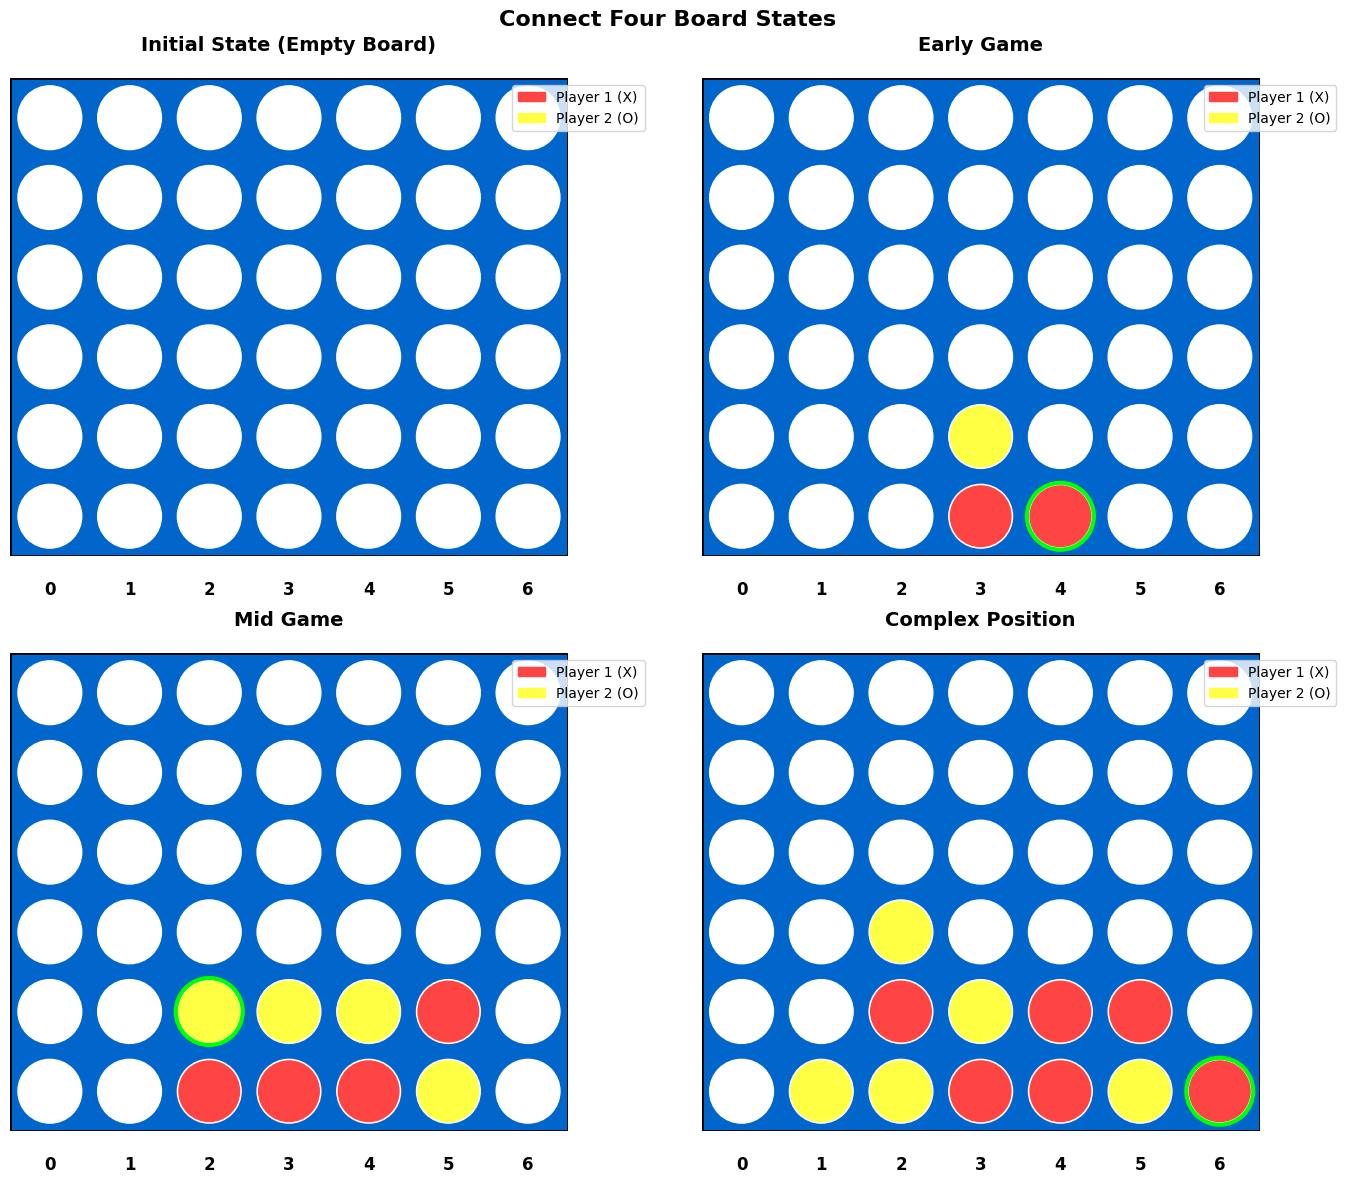

In [15]:
def visualize_board(game: ConnectFour, title="Board", 
                   highlight_last=True, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 7))
    
    # Draw blue board background
    board_rect = patches.Rectangle((0, 0), game.COLS, game.ROWS, 
                                   linewidth=2, edgecolor='black', 
                                   facecolor='#0066cc')
    ax.add_patch(board_rect)
    
    # Draw circles for each position
    for row in range(game.ROWS):
        for col in range(game.COLS):
            circle = plt.Circle((col + 0.5, game.ROWS - row - 0.5), 0.4, 
                               color='white', zorder=2)
            ax.add_patch(circle)
            
            # Fill with player colors
            if game.board[row][col] == 1:
                piece = plt.Circle((col + 0.5, game.ROWS - row - 0.5), 0.38, 
                                  color='#ff4444', zorder=3)
                ax.add_patch(piece)
            elif game.board[row][col] == 2:
                piece = plt.Circle((col + 0.5, game.ROWS - row - 0.5), 0.38, 
                                  color='#ffff44', zorder=3)
                ax.add_patch(piece)
            
            # Highlight last move
            if highlight_last and game.last_move and (row, col) == game.last_move:
                highlight = plt.Circle((col + 0.5, game.ROWS - row - 0.5), 0.42, 
                                      color='lime', fill=False, linewidth=3, zorder=4)
                ax.add_patch(highlight)
    
    # Set axis properties
    ax.set_xlim(0, game.COLS)
    ax.set_ylim(0, game.ROWS)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Add column labels
    for col in range(game.COLS):
        ax.text(col + 0.5, -0.3, str(col), ha='center', va='top', 
               fontsize=12, fontweight='bold')
    
    # Add legend
    red_patch = patches.Patch(color='#ff4444', label='Player 1 (X)')
    yellow_patch = patches.Patch(color='#ffff44', label='Player 2 (O)')
    ax.legend(handles=[red_patch, yellow_patch], loc='upper right', 
             bbox_to_anchor=(1.15, 1.0))
    
    return ax


# Test board visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Connect Four Board States', fontsize=16, fontweight='bold')

# Empty board
game_empty = ConnectFour()
visualize_board(game_empty, "Initial State (Empty Board)", highlight_last=False, ax=axes[0, 0])

# Early game
game_early = ConnectFour()
for col in [3, 3, 4]:
    game_early.make_move(col)
visualize_board(game_early, "Early Game", ax=axes[0, 1])

# Mid game
game_mid = ConnectFour()
for col in [3, 3, 4, 4, 2, 5, 5, 2]:
    game_mid.make_move(col)
visualize_board(game_mid, "Mid Game", ax=axes[1, 0])

# Complex position
game_complex = ConnectFour()
for col in [3, 2, 4, 3, 2, 5, 4, 2, 5, 1, 6]:
    game_complex.make_move(col)
visualize_board(game_complex, "Complex Position", ax=axes[1, 1])

plt.tight_layout()
plt.show()

### Tree Visualization

Minimax tree


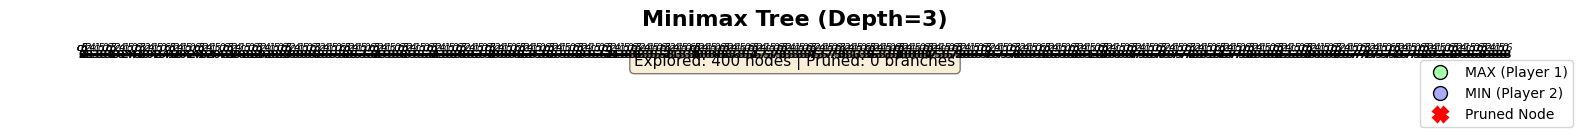

Alpha-Beta tree


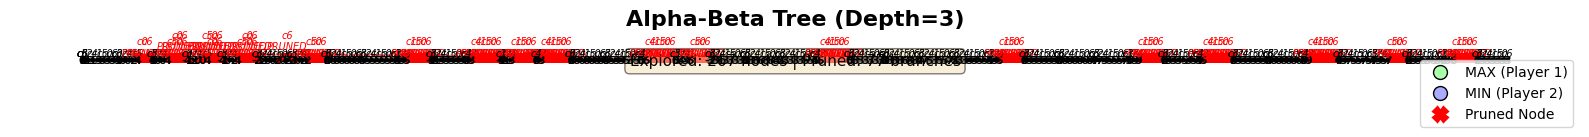

In [13]:
class GameTree:

    def __init__(self, game: ConnectFour, max_depth: int = 3):
        self.game = game
        self.max_depth = max_depth
        self.evaluator = Evaluator(game)
        self.tree_nodes = []  # Store (state, depth, value, move, is_explored)
        
    # Build game tree for Minimax
    def build_tree_minimax(self, game_state: ConnectFour, depth: int, 
                          maximizing: bool, player: int, parent_id: int = 0, 
                          move: int = None):
        node_id = len(self.tree_nodes)
        
        # depth limit
        if depth == 0 or game_state.is_game_done():
            if game_state.is_game_done():
                winner = game_state.check_winner()
                if winner == player:
                    value = 1000
                elif winner:
                    value = -1000
                else:
                    value = 0
            else:
                value = self.evaluator.evaluate_position(game_state.board, player)
            
            self.tree_nodes.append({
                'id': node_id,
                'parent_id': parent_id,
                'depth': self.max_depth - depth,
                'move': move,
                'value': value,
                'is_explored': True,
                'is_pruned': False,
                'maximizing': maximizing
            })
            return value
        
        valid_moves = game_state.get_valid_moves()
        center_col = game_state.COLS // 2
        valid_moves = sorted(valid_moves, key=lambda x: abs(x - center_col))
        
        if maximizing:
            max_val = float('-inf')
            for move in valid_moves:
                child = game_state.copy()
                child.make_move(move)
                val = self.build_tree_minimax(child, depth - 1, False, player, node_id, move)
                max_val = max(max_val, val)
            
            self.tree_nodes.append({
                'id': node_id,
                'parent_id': parent_id,
                'depth': self.max_depth - depth,
                'move': move,
                'value': max_val,
                'is_explored': True,
                'is_pruned': False,
                'maximizing': maximizing
            })
            return max_val
        else:
            min_val = float('inf')
            for move in valid_moves:
                child = game_state.copy()
                child.make_move(move)
                val = self.build_tree_minimax(child, depth - 1, True, player, node_id, move)
                min_val = min(min_val, val)
            
            self.tree_nodes.append({
                'id': node_id,
                'parent_id': parent_id,
                'depth': self.max_depth - depth,
                'move': move,
                'value': min_val,
                'is_explored': True,
                'is_pruned': False,
                'maximizing': maximizing
            })
            return min_val
    
    # Build game tree for Alpha-Beta
    def build_tree_alphabeta(self, game_state: ConnectFour, depth: int,
                           alpha: float, beta: float,
                           maximizing: bool, player: int, 
                           parent_id: int = 0, move: int = None):
        node_id = len(self.tree_nodes)
        
        # Terminal or depth limit
        if depth == 0 or game_state.is_game_done():
            if game_state.is_game_done():
                winner = game_state.check_winner()
                if winner == player:
                    value = 1000
                elif winner:
                    value = -1000
                else:
                    value = 0
            else:
                value = self.evaluator.evaluate_position(game_state.board, player)
            
            self.tree_nodes.append({
                'id': node_id,
                'parent_id': parent_id,
                'depth': self.max_depth - depth,
                'move': move,
                'value': value,
                'is_explored': True,
                'is_pruned': False,
                'maximizing': maximizing
            })
            return value
        
        valid_moves = game_state.get_valid_moves()
        center_col = game_state.COLS // 2
        valid_moves = sorted(valid_moves, key=lambda x: abs(x - center_col))
        
        if maximizing:
            max_val = float('-inf')
            for i, move in enumerate(valid_moves):
                if beta <= alpha:
                    # Mark remaining moves as pruned
                    for remaining_move in valid_moves[i:]:
                        self.tree_nodes.append({
                            'id': len(self.tree_nodes),
                            'parent_id': node_id,
                            'depth': self.max_depth - depth + 1,
                            'move': remaining_move,
                            'value': None,
                            'is_explored': False,
                            'is_pruned': True,
                            'maximizing': not maximizing
                        })
                    break
                
                child = game_state.copy()
                child.make_move(move)
                val = self.build_tree_alphabeta(child, depth - 1, alpha, beta,
                                              False, player, node_id, move)
                max_val = max(max_val, val)
                alpha = max(alpha, val)
            
            self.tree_nodes.append({
                'id': node_id,
                'parent_id': parent_id,
                'depth': self.max_depth - depth,
                'move': move,
                'value': max_val,
                'is_explored': True,
                'is_pruned': False,
                'maximizing': maximizing
            })
            return max_val
        else:
            min_val = float('inf')
            for i, move in enumerate(valid_moves):
                if beta <= alpha:
                    # Mark remaining moves as pruned
                    for remaining_move in valid_moves[i:]:
                        self.tree_nodes.append({
                            'id': len(self.tree_nodes),
                            'parent_id': node_id,
                            'depth': self.max_depth - depth + 1,
                            'move': remaining_move,
                            'value': None,
                            'is_explored': False,
                            'is_pruned': True,
                            'maximizing': not maximizing
                        })
                    break
                
                child = game_state.copy()
                child.make_move(move)
                val = self.build_tree_alphabeta(child, depth - 1, alpha, beta,
                                              True, player, node_id, move)
                min_val = min(min_val, val)
                beta = min(beta, val)
            
            self.tree_nodes.append({
                'id': node_id,
                'parent_id': parent_id,
                'depth': self.max_depth - depth,
                'move': move,
                'value': min_val,
                'is_explored': True,
                'is_pruned': False,
                'maximizing': maximizing
            })
            return min_val
    
    # Visualize the game tree
    def visualize_tree(self, algorithm='minimax', figsize=(16, 10)):
        fig, ax = plt.subplots(figsize=figsize)
        
        # Build tree
        self.tree_nodes = []
        if algorithm == 'minimax':
            self.build_tree_minimax(self.game, self.max_depth, True, 1)
            title = f"Minimax Tree (Depth={self.max_depth})"
        else:
            self.build_tree_alphabeta(self.game, self.max_depth, 
                                    float('-inf'), float('inf'), True, 1)
            title = f"Alpha-Beta Tree (Depth={self.max_depth})"
        
        # Count nodes per depth
        depth_counts = defaultdict(int)
        for node in self.tree_nodes:
            depth_counts[node['depth']] += 1
        
        # Position nodes
        node_positions = {}
        depth_x_positions = defaultdict(lambda: 0)
        
        for node in sorted(self.tree_nodes, key=lambda x: (x['depth'], x['id'])):
            depth = node['depth']
            x = depth_x_positions[depth]
            y = -depth * 2
            node_positions[node['id']] = (x, y)
            depth_x_positions[depth] += 1.5
        
        # Draw edges
        for node in self.tree_nodes:
            if node['parent_id'] in node_positions and node['id'] in node_positions:
                parent_pos = node_positions[node['parent_id']]
                node_pos = node_positions[node['id']]
                
                if node['is_pruned']:
                    ax.plot([parent_pos[0], node_pos[0]], 
                           [parent_pos[1], node_pos[1]], 
                           'r--', alpha=0.3, linewidth=1)
                else:
                    ax.plot([parent_pos[0], node_pos[0]], 
                           [parent_pos[1], node_pos[1]], 
                           'k-', alpha=0.5, linewidth=1.5)
        
        # Draw nodes
        for node in self.tree_nodes:
            if node['id'] not in node_positions:
                continue
            
            x, y = node_positions[node['id']]
            
            if node['is_pruned']:
                color = '#ffcccc'
                marker = 'X'
            elif node['maximizing']:
                color = '#aaffaa'
                marker = '▲'
            else:
                color = '#aaaaff'
                marker = '▼'
            
            if node['is_explored']:
                circle = plt.Circle((x, y), 0.4, color=color, 
                                   ec='black', linewidth=2, zorder=3)
                ax.add_patch(circle)
                
                # Add value text
                if node['value'] is not None:
                    ax.text(x, y, f"{node['value']:.0f}", 
                           ha='center', va='center', fontsize=8, 
                           fontweight='bold', zorder=4)
                
                # Add move label
                if node['move'] is not None:
                    ax.text(x, y + 0.6, f"c{node['move']}", 
                           ha='center', va='bottom', fontsize=7, 
                           style='italic', zorder=4)
            else:
                # Pruned node
                ax.plot(x, y, 'rx', markersize=15, markeredgewidth=3, zorder=3)
                ax.text(x, y + 0.6, f"c{node['move']}\nPRUNED", 
                       ha='center', va='bottom', fontsize=7, 
                       color='red', style='italic', zorder=4)
        
        # Formatting
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
        
        # Add legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#aaffaa',
                  markersize=10, label='MAX (Player 1)', markeredgecolor='black'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#aaaaff',
                  markersize=10, label='MIN (Player 2)', markeredgecolor='black'),
            Line2D([0], [0], marker='X', color='r', linestyle='None',
                  markersize=10, label='Pruned Node', markeredgewidth=2)
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
        
        # Stats
        explored = sum(1 for n in self.tree_nodes if n['is_explored'])
        pruned = sum(1 for n in self.tree_nodes if n['is_pruned'])
        stats_text = f"Explored: {explored} nodes | Pruned: {pruned} branches"
        ax.text(0.5, 0.98, stats_text, transform=ax.transAxes,
               ha='center', va='top', fontsize=11, 
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        return fig

# Test game tree visualization
viz_game = ConnectFour()
viz_game.make_move(3, 1)  # X in col 3

# Visualize Minimax tree
print("Minimax tree")
visualizer_mm = GameTree(viz_game, max_depth=3)
fig_mm = visualizer_mm.visualize_tree('minimax')
plt.show()

# Visualize Alpha-Beta tree
print("Alpha-Beta tree")
visualizer_ab = GameTree(viz_game, max_depth=3)
fig_ab = visualizer_ab.visualize_tree('alphabeta')
plt.show()


### Performance Comparison Visualization

Running performance comparison across multiple depths...
This may take a moment...

Testing depth 3...
Testing depth 4...
Testing depth 5...
Testing depth 6...


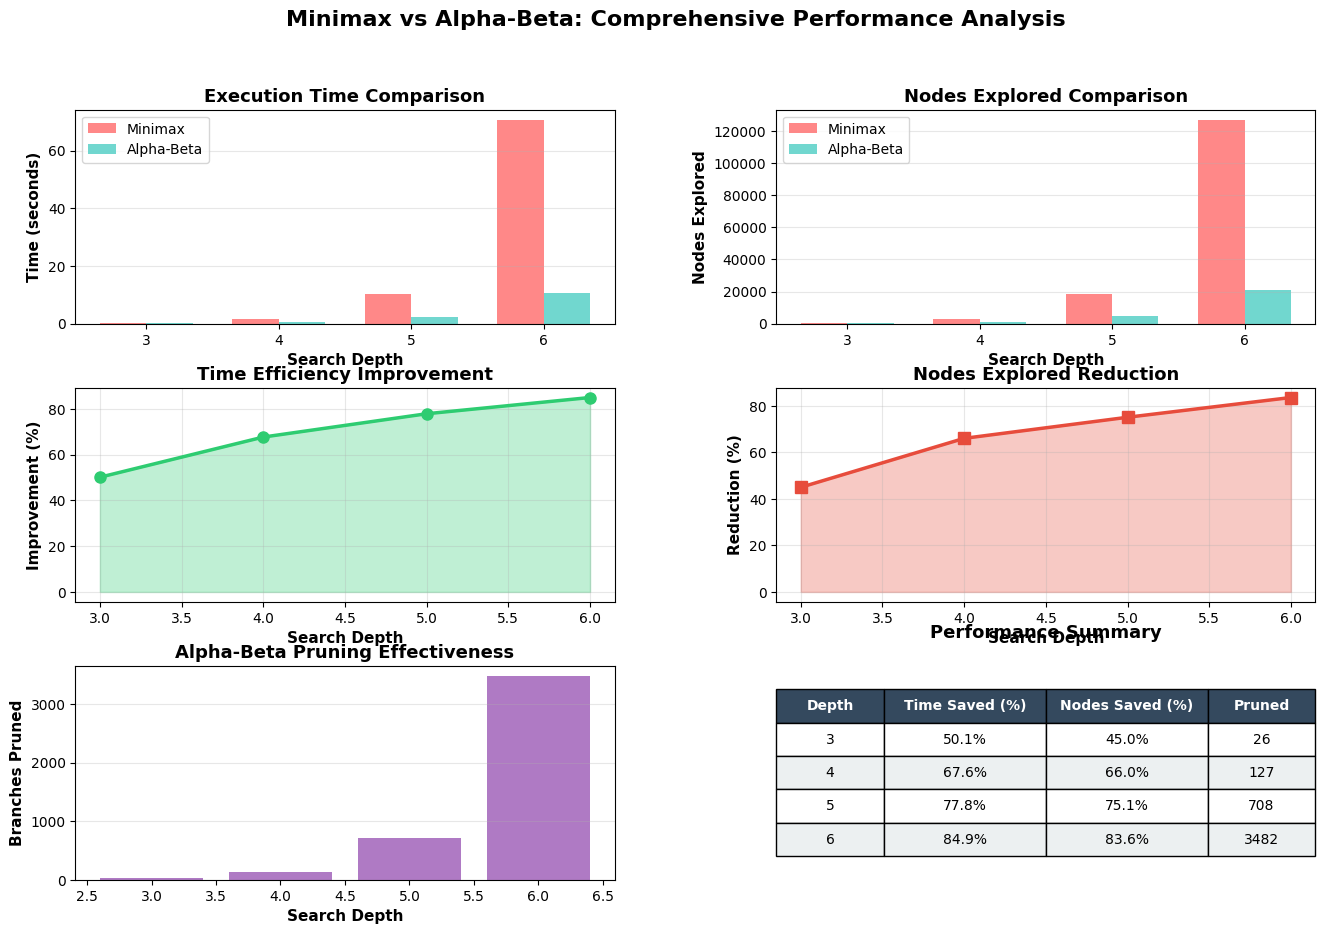


PERFORMANCE SUMMARY
Average Time Improvement: 70.11%
Average Nodes Reduction: 67.44%
Total Branches Pruned: 4343


In [ ]:
def perform_comp_visual(test_depths=[3, 4, 5, 6]):
    results = {
        'depths': [],
        'minimax_time': [],
        'alphabeta_time': [],
        'minimax_nodes': [],
        'alphabeta_nodes': [],
        'pruning_counts': []
    }
    
    # Test game state
    test_game = ConnectFour()
    test_game.make_move(3, 1)
    test_game.make_move(3, 2)
    test_game.make_move(4, 1)
    
    for depth in test_depths:
        print(f"Testing depth {depth}")
        
        # Minimax
        mm_agent = MinimaxAgent(test_game, max_depth=depth)
        _, mm_metrics = mm_agent.get_best_move(test_game, 2)
        
        # Alpha-Beta
        ab_agent = AlphaBetaAgent(test_game, max_depth=depth)
        _, ab_metrics = ab_agent.get_best_move(test_game, 2)
        
        results['depths'].append(depth)
        results['minimax_time'].append(mm_metrics['time_taken'])
        results['alphabeta_time'].append(ab_metrics['time_taken'])
        results['minimax_nodes'].append(mm_metrics['nodes_explored'])
        results['alphabeta_nodes'].append(ab_metrics['nodes_explored'])
        results['pruning_counts'].append(ab_metrics['pruning_count'])
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Time Comparison
    ax1 = fig.add_subplot(gs[0, 0])
    x = results['depths']
    width = 0.35
    x_pos = np.arange(len(x))
    
    ax1.bar(x_pos - width/2, results['minimax_time'], width, 
           label='Minimax', color='#ff6b6b', alpha=0.8)
    ax1.bar(x_pos + width/2, results['alphabeta_time'], width,
           label='Alpha-Beta', color='#4ecdc4', alpha=0.8)
    ax1.set_xlabel('Search Depth', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
    ax1.set_title('Execution Time Comparison', fontsize=13, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Nodes Explored Comparison
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.bar(x_pos - width/2, results['minimax_nodes'], width,
           label='Minimax', color='#ff6b6b', alpha=0.8)
    ax2.bar(x_pos + width/2, results['alphabeta_nodes'], width,
           label='Alpha-Beta', color='#4ecdc4', alpha=0.8)
    ax2.set_xlabel('Search Depth', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Nodes Explored', fontsize=11, fontweight='bold')
    ax2.set_title('Nodes Explored Comparison', fontsize=13, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Time Improvement %
    ax3 = fig.add_subplot(gs[1, 0])
    time_improvements = [(mm - ab) / mm * 100 
                        for mm, ab in zip(results['minimax_time'], 
                                         results['alphabeta_time'])]
    ax3.plot(x, time_improvements, marker='o', linewidth=2.5, 
            markersize=8, color='#2ecc71')
    ax3.fill_between(x, time_improvements, alpha=0.3, color='#2ecc71')
    ax3.set_xlabel('Search Depth', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Improvement (%)', fontsize=11, fontweight='bold')
    ax3.set_title('Time Efficiency Improvement', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. Nodes Reduction %
    ax4 = fig.add_subplot(gs[1, 1])
    nodes_improvements = [(mm - ab) / mm * 100 
                         for mm, ab in zip(results['minimax_nodes'], 
                                          results['alphabeta_nodes'])]
    ax4.plot(x, nodes_improvements, marker='s', linewidth=2.5,
            markersize=8, color='#e74c3c')
    ax4.fill_between(x, nodes_improvements, alpha=0.3, color='#e74c3c')
    ax4.set_xlabel('Search Depth', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Reduction (%)', fontsize=11, fontweight='bold')
    ax4.set_title('Nodes Explored Reduction', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5. Pruning Count
    ax5 = fig.add_subplot(gs[2, 0])
    ax5.bar(x, results['pruning_counts'], color='#9b59b6', alpha=0.8)
    ax5.set_xlabel('Search Depth', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Branches Pruned', fontsize=11, fontweight='bold')
    ax5.set_title('Alpha-Beta Pruning Effectiveness', fontsize=13, fontweight='bold')
    ax5.grid(axis='y', alpha=0.3)
    
    # 6. Summary Table
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.axis('tight')
    ax6.axis('off')
    
    table_data = [['Depth', 'Time Saved (%)', 'Nodes Saved (%)', 'Pruned']]
    for i, depth in enumerate(x):
        table_data.append([
            str(depth),
            f"{time_improvements[i]:.1f}%",
            f"{nodes_improvements[i]:.1f}%",
            str(results['pruning_counts'][i])
        ])
    
    table = ax6.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.2, 0.3, 0.3, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style header row
    for i in range(4):
        table[(0, i)].set_facecolor('#34495e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Alternate row colors
    for i in range(1, len(table_data)):
        for j in range(4):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#ecf0f1')
            else:
                table[(i, j)].set_facecolor('#ffffff')
    
    ax6.set_title('Performance Summary', fontsize=13, fontweight='bold', pad=20)
    
    fig.suptitle('Minimax vs Alpha-Beta: Comprehensive Performance Analysis', 
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.show()
    
    # Print summary
    print("===============================================")
    print("PERFORMANCE SUMMARY")
    print("===============================================")
    avg_time_improvement = np.mean(time_improvements)
    avg_nodes_reduction = np.mean(nodes_improvements)
    print(f"Average Time Improvement: {avg_time_improvement:.2f}%")
    print(f"Average Nodes Reduction: {avg_nodes_reduction:.2f}%")
    print(f"Total Branches Pruned: {sum(results['pruning_counts'])}")
    print("==============================================\n")
    
    return results


# Run comprehensive comparison
comparison_results = perform_comp_visual([3, 4, 5, 6])

### AI vs AI Game Demonstration

Minimax (X) vs Alpha-Beta (O)

Move 1: Minimax plays column 3
Move 2: Alpha-Beta plays column 1
Move 3: Minimax plays column 4
Move 4: Alpha-Beta plays column 0
Move 5: Minimax plays column 5
Move 6: Alpha-Beta plays column 5
Move 7: Minimax plays column 3
Move 8: Alpha-Beta plays column 5
Move 9: Minimax plays column 3
Move 10: Alpha-Beta plays column 4
Move 11: Minimax plays column 3


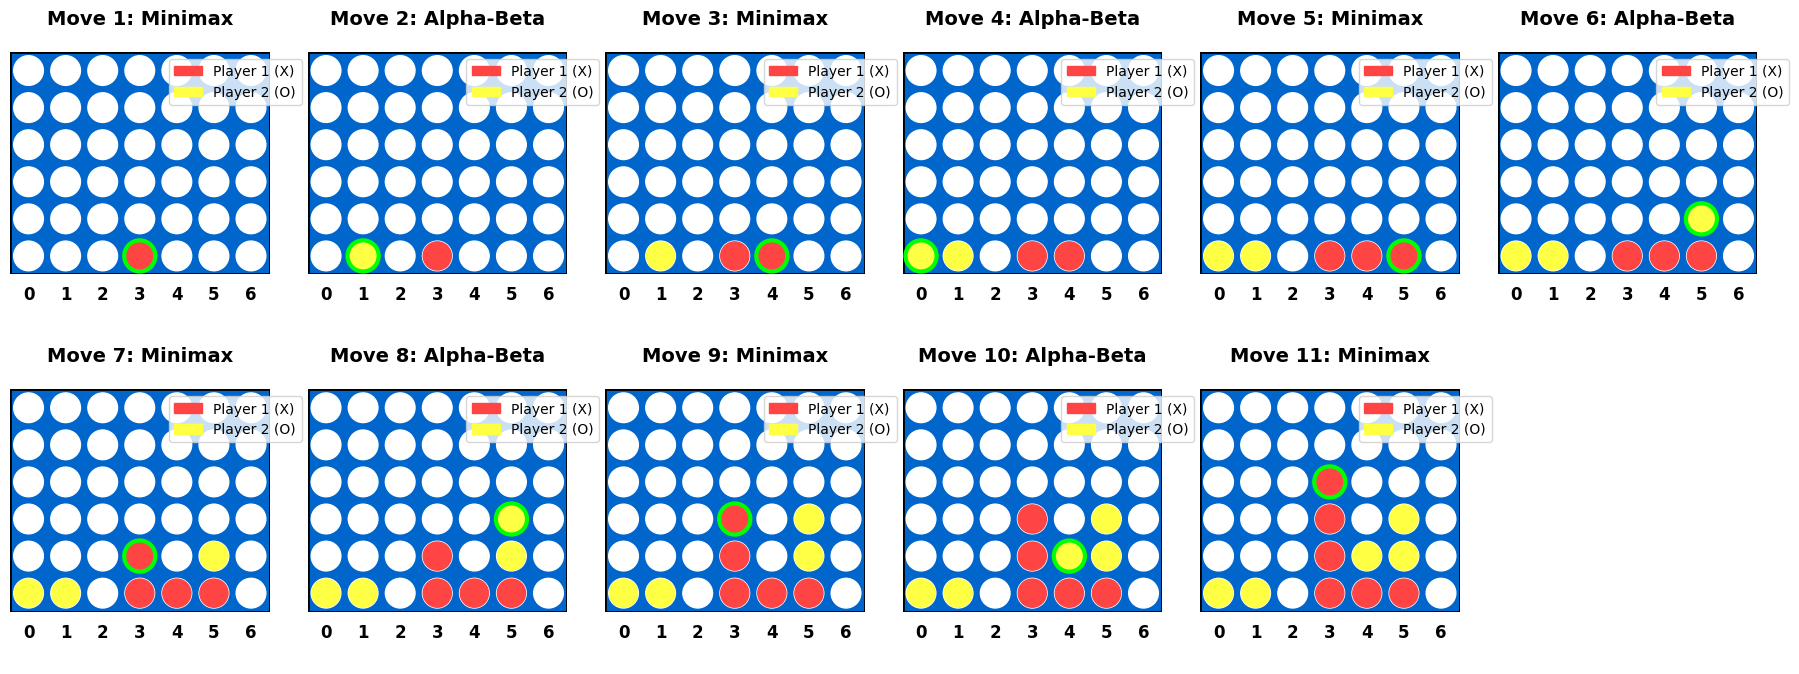


FINAL BOARD

0 1 2 3 4 5 6
-------------
. . . . . . .
. . . . . . .
. . . X . . .
. . . X . O .
. . . X O O .
O O . X X X .


Minimax (Player 1) WINS!
Total moves: 11



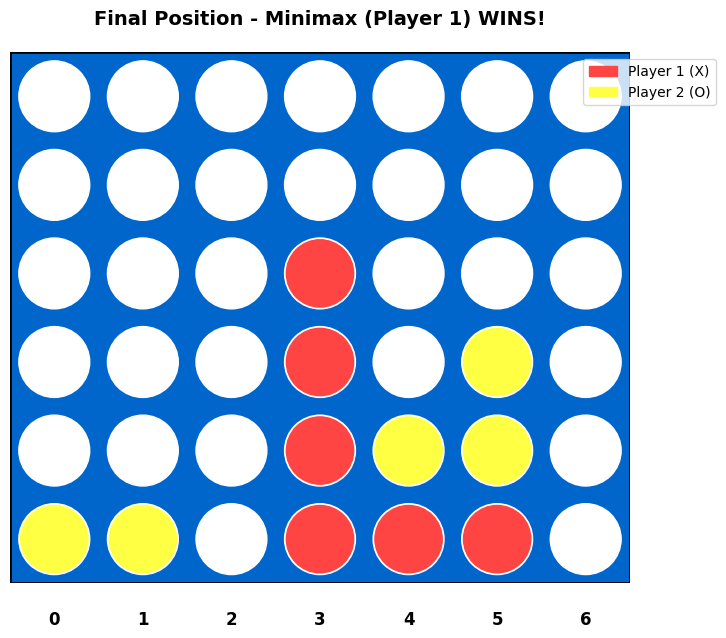

In [16]:
def play_ai_game(agent1, agent2, agent1_name="Minimax", agent2_name="Alpha-Beta", 
                visualize_steps=True):

    game = ConnectFour()
    move_count = 0
    max_moves = 42
    
    game_history = []
    
    print("===============================================")
    print(f"{agent1_name} (X) vs {agent2_name} (O)")
    print("===============================================\n")
    
    if visualize_steps:
        num_cols = min(6, max_moves // 2)
        fig, axes = plt.subplots(2, num_cols, figsize=(num_cols * 3, 7))
        axes = axes.flatten()
        plot_idx = 0
    
    while not game.is_game_done() and move_count < max_moves:
        current_player = game.current_player
        
        if current_player == 1:
            # Agent 1's turn
            move, metrics = agent1.get_best_move(game, current_player)
            agent_name = agent1_name
        else:
            # Agent 2's turn
            move, metrics = agent2.get_best_move(game, current_player)
            agent_name = agent2_name
        
        game.make_move(move)
        move_count += 1
        
        print(f"Move {move_count}: {agent_name} plays column {move}")
        
        game_history.append({
            'move': move_count,
            'player': current_player,
            'column': move,
            'agent': agent_name,
            'board': game.board.copy()
        })
        
        # Visualize selected moves
        if visualize_steps and plot_idx < len(axes):
            ax = axes[plot_idx]
            temp_game = ConnectFour()
            temp_game.board = game.board.copy()
            temp_game.last_move = game.last_move
            visualize_board(temp_game, 
                          f"Move {move_count}: {agent_name}", 
                          ax=ax)
            plot_idx += 1
        
        if game.is_game_done():
            break
    
    if visualize_steps:
        # Hide unused subplots
        for idx in range(plot_idx, len(axes)):
            axes[idx].axis('off')
        plt.tight_layout()
        plt.show()
    
    # Final board
    print(f"\n{'='*60}")
    print("FINAL BOARD")
    print(f"{'='*60}")
    game.display()
    
    winner = game.check_winner()
    if winner == 1:
        result = f"{agent1_name} (Player 1) WINS!"
    elif winner == 2:
        result = f"{agent2_name} (Player 2) WINS!"
    else:
        result = "DRAW!"
    
    print(f"\n{result}")
    print(f"Total moves: {move_count}\n")
    
    return {
        'winner': winner,
        'moves': move_count,
        'result': result,
        'history': game_history,
        'final_board': game.board.copy()
    }


game_demo = ConnectFour()
minimax_player = MinimaxAgent(game_demo, max_depth=5)
alphabeta_player = AlphaBetaAgent(game_demo, max_depth=5)

game_result = play_ai_game(minimax_player, alphabeta_player, 
                          "Minimax", "Alpha-Beta", 
                          visualize_steps=True)

# Visualize final board
fig, ax = plt.subplots(figsize=(8, 7))
final_game = ConnectFour()
final_game.board = game_result['final_board']
visualize_board(final_game, f"Final Position - {game_result['result']}", 
               highlight_last=False, ax=ax)
plt.show()

## Interactive Game

In [ ]:
def play_human_vs_ai(use_alphabeta=True, ai_depth=6):
    game = ConnectFour()
    
    if use_alphabeta:
        ai_agent = AlphaBetaAgent(game, max_depth=ai_depth)
        ai_name = "Alpha-Beta"
    else:
        ai_agent = MinimaxAgent(game, max_depth=ai_depth)
        ai_name = "Minimax"

    
    print("===============================================")
    print(f"CONNECT FOUR: Human (O) vs {ai_name} (X)")
    print("===============================================\n")
    print("You are Player 2 (O) - Enter column number (0-6) to play")
    print("Type 'quit' to exit\n")
    
    while not game.is_game_done():
        game.display()
        
        if game.current_player == 2:
            # player turn
            valid_moves = game.get_valid_moves()
            print(f"Valid moves: {valid_moves}")
            
            while True:
                try:
                    user_input = input("Your move (column 0-6): ").strip()
                    
                    if user_input.lower() == 'quit':
                        print("Game ended by user.")
                        return
                    
                    col = int(user_input)
                    
                    if col in valid_moves:
                        game.make_move(col)
                        print(f"\nYou played column {col}")
                        break
                    else:
                        print("Invalid move! Try again.")
                except ValueError:
                    print("Please enter a valid number (0-6) or 'quit'")
        
        else:
            # AI's turn
            print(f"\n{ai_name} turn")
            start = time.time()
            move, metrics = ai_agent.get_best_move(game, 2)
            elapsed = time.time() - start
            
            game.make_move(move)
            print(f"{ai_name} played column {move}")
            print(f"(Explored {metrics['nodes_explored']} nodes in {elapsed:.2f}s)")
        
        print()
        
        if game.is_game_done():
            break
    
    # Game over
    game.display()
    winner = game.check_winner()
    
    print("===============================================")
    if winner == 2:
        print("You win!")
    elif winner == 1:
        print(f"{ai_name} wins!")
    else:
        print("It's a draw!")
    print("===============================================\n")
    
    # Visualize final board
    fig, ax = plt.subplots(figsize=(8, 7))
    visualize_board(game, "Final Position", highlight_last=False, ax=ax)
    plt.show()


play_human_vs_ai(use_alphabeta=True, ai_depth=6)